# Aula 15 - Entregas Pre-Treino Projeto Final

# Pre-treino no RVL-CDIP Usando Patches (ViT - Vision Transformer) usando T5 base

**Nesse notebook foi implementado apenas o pre-treino no dataset RVL-CDIP**


**O dataset RVL-CDIP é um dataset com 36GB de documentos com 320000, 40000, 39999 de dados de treino, validação e teste.**


**Esse dataset de padrão não tem os targets. O labels foram obtidos via OCR (chamado de tesseract) aplicados conforme (https://github.com/Quicksign/ocrized-text-dataset/releases).**


#### Dataset das imagens RVL-CDIP

https://www.kaggle.com/orllem456/rvlcdip

#### Dataset do labels das imagens 
https://www.kaggle.com/orllem456/qsocrlarge


## Nessa parte final consegui

1. **Terminar o pre-treino no dataset real RVL-CDIP.**


2. **O modelo atinge um F1 de 6.5%. O que não é uma boa performance.**


3. **O exact match é muito baixo atingindo 0.225%**


3. **O treino foi executado por 10 dias.**

In [1]:
from google.colab import drive
from google.colab import files

# download_kaggle=False
download_kaggle=True

if download_kaggle:

  # Run this cell and select the kaggle.json file downloaded
  # from the Kaggle account settings page.
  
  files.upload()

  drive.mount('/content/drive')

  # Let's make sure the kaggle.json file is present.
  !ls -lha kaggle.json

  # Next, install the Kaggle API client.
  !pip install -q kaggle

  #The Kaggle API client expects this file to be in ~/.kaggle,
  #so move it there.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json

  # Copy the stackoverflow data set locally.
  !kaggle datasets download -d 'orllem456/rvlcdip'

  !unzip -q rvlcdip.zip -d rvlcdip

  !rm rvlcdip.zip

  !kaggle datasets download -d 'orllem456/qsocrlarge'

  !unzip -q qsocrlarge.zip -d qsocrlarge

Saving kaggle.json to kaggle.json
Mounted at /content/drive
-rw-r--r-- 1 root root 65 Jan 13 04:00 kaggle.json
100% 36.1G/36.1G [11:04<00:00, 65.5MB/s]
100% 36.1G/36.1G [11:04<00:00, 58.4MB/s]
100% 322M/323M [00:12<00:00, 26.5MB/s]
100% 323M/323M [00:12<00:00, 26.2MB/s]


In [2]:
import gc

In [3]:
gc.collect()

15

# Pre-train

In [4]:
version = "patch_adafactor_gpu_model" #@param {type: "string"}
bs =  6#@param {type: "integer"} 
seq_len =  512#@param {type: "integer"}
patch_size = 20#@param {type: "integer"}
patience =  1#@param {type: "integer"} 
max_epochs =  4#@param {type: "integer"}
dropout_rate_t5 = 0.01#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "bs": bs,
           "seq_len": seq_len,
           "patch_size": patch_size,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate_t5": dropout_rate_t5,
           "debug": debug, 
           "t5": "t5-base"}
hparams             

{'bs': 6,
 'debug': False,
 'dropout_rate_t5': 0.01,
 'max_epochs': 4,
 'patch_size': 20,
 'patience': 1,
 'seq_len': 512,
 't5': 't5-base',
 'version': 'patch_adafactor_gpu_model'}

In [5]:
import matplotlib.pyplot as plt
import cv2

In [6]:
array_to_remove = [1,3,4,5,6,7,8,9]
print(array_to_remove)

[1, 3, 4, 5, 6, 7, 8, 9]


In [7]:
myfile1 = open('qsocrlarge/text_train.txt', "r")
num_lines1 = sum(1 for line in myfile1)
print('len of train:', num_lines1)
myfile1.close()

myfile2 = open('qsocrlarge/text_val.txt', "r")
num_lines2 = sum(1 for line in myfile2)
print('len of val:', num_lines2)
myfile2.close()

myfile3 = open('qsocrlarge/text_test.txt', "r")
num_lines3 = sum(1 for line in myfile3)
print('len of test:', num_lines3)
myfile3.close()

len of train: 320000
len of val: 40000
len of test: 39999


In [8]:
del myfile1, myfile2, myfile3
gc.collect()

0

In [9]:
!pip install neptune-client --quiet  

     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 829kB 21.0MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 204kB 65.8MB/s 
     |████████████████████████████████| 163kB 70.0MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 133kB 57.5MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 


In [10]:
!pip install fairseq --quiet  

     |████████████████████████████████| 1.7MB 4.0MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 133kB 57.5MB/s 
     |████████████████████████████████| 112kB 44.5MB/s 
     |████████████████████████████████| 276kB 46.7MB/s 


In [11]:
!pip install transformers==3.5.1 --quiet  

     |████████████████████████████████| 1.3MB 5.4MB/s 
     |████████████████████████████████| 2.9MB 14.5MB/s 
     |████████████████████████████████| 1.1MB 63.4MB/s 
     |████████████████████████████████| 890kB 62.5MB/s 


In [12]:
!pip install pytorch-lightning --quiet      

     |████████████████████████████████| 686kB 4.2MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 1.3MB 63.6MB/s 
     |████████████████████████████████| 143kB 48.9MB/s 
     |████████████████████████████████| 296kB 78.0MB/s 


In [13]:
import random
import pytorch_lightning as pl
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from fairseq.optim import adafactor
import sys

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan 13 04:24:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

In [16]:
MODES = ["train", "val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do OCR_DATA com o dataset RVL CDIP  
    '''
    def __init__(self, mode, seq_len, t5_model, width=300, height=400,image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: 2.0*(img - 1.0))])):
      '''
      mode: um de "train", "val", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len

      self.TOKENIZER = t5_model
      # self.TOKENIZER = T5Tokenizer.from_pretrained(t5_model)

      self.image_transform = image_transform
      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
        
      file = open('qsocrlarge/text_' + mode + '.txt', "r")    

      self.targets = list()
      self.images_path = list()
      for txt_file in file:
          # print(txt_file.split(' ')[1])
          if int(txt_file.split(' ')[1]) not in array_to_remove:
            self.images_path.append('rvlcdip/images/' + txt_file.split(' ')[0][:-4]+'.tif')
            with open('qsocrlarge/' + txt_file.split(' ')[0], 'r') as target_file:
                  line = target_file.read().replace("\n", " ")
                  self.targets.append(line)
      
      file.close()
      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do .tif, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        caption = self.targets[i]

        target = self.TOKENIZER.encode(caption,
                                    padding='max_length',
                                    truncation=True,
                                    max_length=self.seq_len,
                                    return_tensors='pt')[0]                          
        
        im_bgr = cv2.imread(self.images_path[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        image = self.reshape_trans(im_rgb)

        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=4):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [17]:
train_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

In [18]:
datasets = {"train": OCR_DATA("train", hparams['seq_len'], TOKENIZER, image_transform=train_transforms), "val": OCR_DATA("val", hparams['seq_len'], TOKENIZER,  image_transform=train_transforms),
            "test": OCR_DATA("test", hparams['seq_len'], TOKENIZER, image_transform=test_transforms)}

In [19]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}
print(f"Lens: {dataset_lens}")

Lens: {'train': 160120, 'val': 19965, 'test': 19915}


max image tensor(0.)
min image tensor(-1.6549)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
label: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hos

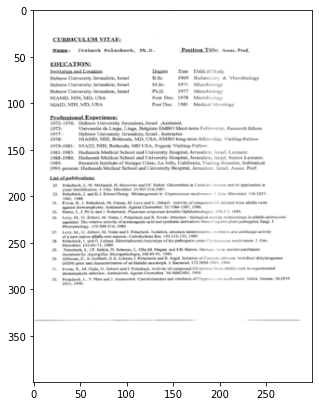

In [20]:
image = datasets["train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow((image.cpu().numpy().transpose(1, 2, 0)/2+1))

label = datasets["train"][2][1]
print('label:', label)

target = datasets["train"][2][2]
print('target:', target)

In [21]:
# display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}


# # Test-load batchs 
# train_batch, val_batch, test_batch = next(iter(display_dataloaders["train"])), next(iter(display_dataloaders["val"])), next(iter(display_dataloaders["test"]))

# print("Train batch")
# for image, label, target in zip(train_batch[0], train_batch[1], train_batch[2]):
#   plt.figure(figsize=(4, 10))
#   print(f"Label: {label}")
#   plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
#   plt.show()  
# print('----------------------------------------')


# print("Val batch")
# for image, label, target in zip(val_batch[0], val_batch[1], val_batch[2]):
#   plt.figure(figsize=(4, 10))
#   print(f"Label: {label}")
#   plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
#   plt.show()
    
# print('----------------------------------------')    

# print("Test batch")
# for image, label, target in zip(test_batch[0], test_batch[1], train_batch[2]):
#   plt.figure(figsize=(4, 10))
#   print(f"Label: {label}")
#   plt.imshow((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1))
#   plt.show()

In [22]:
# del display_dataloaders, train_batch, val_batch, test_batch
# gc.collect()

In [23]:
torch.cuda.empty_cache()

In [24]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [25]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params

        self.decoder = T5ForConditionalGeneration.from_pretrained(pretrained_model_name_or_path=params['t5'], dropout_rate=params['dropout_rate_t5'])
        
        # Patch convolution. Basically tranform the 2D image into 16x16 patches with 2048 dimensions.
        # self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_ff, kernel_size=20, stride=16, padding=4)
        # self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_model, kernel_size=20, stride=16, padding=4)
        
        self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_model, kernel_size=params['patch_size'], stride=params['patch_size'])
        
        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):
        
        # kernel_size=20, stride=16, padding=4
        # images shape torch.Size([4, 3, 400, 300])
        # features shape torch.Size([4, 512, 25, 19])
        # efn_embeddings torch.Size([4, 475, 512])
        
        # print('images shape', images.shape)

        
        features = self.patch(images)

        # print('features shape', features.shape)

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 2)\
            .reshape(features.shape[0], -1, self.decoder.config.d_model)
        
        # print('efn_embeddings', efn_embeddings.shape)

        
        
        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        # efn_embeddings = self.drop(efn_embeddings)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]

        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]

        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 4)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)
  
        self.log("val_loss", val_loss, prog_bar=True)      
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)

        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)

    def configure_optimizers(self):
        optimizer = adafactor.Adafactor(self.parameters()) 
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.params['patience'])
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return datasets["train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)   
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

In [26]:
# del model
# del trainer
torch.cuda.empty_cache()
gc.collect()

2448

# Overfitting em 2 batches

In [27]:

# pre_model = "drive/My Drive/aula12_checkpoints/patch_adafactor_gpu_model-epoch=0-step=1067.ckpt"
# model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
model = EfficientT5(hparams)
# print(model)

trainer = pl.Trainer(gpus=1,
                     max_epochs=100,
                     benchmark=True,
                     progress_bar_refresh_rate=20,
                     accumulate_grad_batches=25,
                     check_val_every_n_epoch=10,
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     overfit_batches=2)

torch.autograd.set_detect_anomaly(True)

trainer.fit(model)

trainer.test(model)
del model  # Para não ter estouro de mémoria da GPU
del trainer
gc.collect()
torch.cuda.empty_cache()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 222 M 
1 | patch   | Conv2d                     | 922 K 
-------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You requested to overfit but enabled test/val dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)



Sample Target:  * SOT Inhalation SS Ballot 2505168109 Page 1 of 4 RH Biel Sl xls ele a com (SMTP somal pedo) Cop     From: sot@mail.xpet To: haussmann.hansj@pmintl.ch ce: f Subject: SOT Inhalation S$ Ballot 7Q Sent: __2/3/004:48 PM Importance: __ Normal [ Battor SOT Inhalation Specialty Section | Officers for 2000  | rhe totowing are the nominees for offices ofthe Inka foro more han onc candle for cach positon and ratura the ball tothe SOT Headquarters oftice no ater than Rarch 6, 3000. Biographical sketches ofthe candldate are include Vice President Elect (select one) } Vincent Castranova Terry Gordon | Councilor (select two) __Terry Mast ____Kent E. Pinkerton ___Rudy Vatentine | Patricia A. Weideman  Signature: Date: | Please Return by March 6, 2000 to: Society of Toxicology Inhalation Section Ballot 1767 Business Center Drive, Reston, VA 20190-5332 Fax: 703-438-3113  Inhalation Specialty Seetion Candidates for 2000 | candidates for Vice President Elect (vote for one)     Vincent Ca

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)



Sample Target:  JONES. DAY. REAVIS & POGUE} CLEVELAND. OnIO 4aste   November 15, 1995 Mary F. Ward, Esquire Counsel - RED Account $86655-009-033 R.J. Reynolds Tobacco Company Invoice No. 01510540 Bowman Gray Technical Center 1100 Reynolds Boulevard Winston-Salem, NC 27102  Yo all legai servican rendered  from Septembi  2, 1995 Lhrough “ October 21, 1995 in connaction with Total OSHA Hours Lawyers: J.C. MeBlveen, Jz. Total Lawyer Sollars Raralesals/ Project Assistants J. R. Kent “otal Paralegal Dollars SDRAP/CLADMNDL Doe: 3200,1, © FB6SL TEL O16 ONFTRATD  the Indoor Air Quality (OSEA) matter $ 9,550.00 42.25 Hours errs $ 8,515.00 Moura : 082 $ 1,035.00 Rayon 103 EMOTO: S6-16-812 AN SANOP:AB INS ase nga 10.  LETL ottzs 
Prediction: 


Sample Target: 203002231 PRODUCED, John Jewell (Last) NeRrotGrabsnn-ttast) NICK BROOKES C. L. SCHOENBACHLER MICK MCGRAW BOB BEXON JOHN JEWELL TONY BURKE FROM: _ E. PEPPLES  DATE: OCTOBER 22, 1997  RE: lettlement uth Warnings on Certain rduuct  This memo re


Sample Target: To: FROM: SUBJECT: According Materials in Beagle materials Seuillard MEMORANDUM. J.D. Heck A. P. Deaton Solubility of Materials for Acute Cardiovascular and Respiratory Studies to the soP for the Determination of Solubility of for Acute Cardiovascular and Respiratory Effects study Dogs, the solubilities of the most recently tested are provided as follows: A. Soluble according to this Sop: B61, B199. Jeb: Xe: EB. W. Onmilis. 2 Destin R. B. Deaton Crouse TzSSe008
Prediction: * SOT Inhalation SS Ballot 2505168109 Page 1 of 4 RH Biel Sl xls ele a com (SMTP somal pedo) Cop From: sot@mail.xpet To: haussmann.hansj@pmintl.ch ce: f Subject: SOT Inhalation S$ Ballot 7Q Sent: __2/3/004:48 PM Importance: __ Normal [ Battor SOT Inhalation Specialty Section | Officers for 2000 | rhe totowing are the nominees for offices ofthe Inka foro more han onc candle for cach positon and ratura the ball tothe SOT Headquarters oftice no ater than Rarch 6, 3000. Biographical sketches ofthe candlda


Sample Target: To: FROM: SUBJECT: According Materials in Beagle materials Seuillard MEMORANDUM. J.D. Heck A. P. Deaton Solubility of Materials for Acute Cardiovascular and Respiratory Studies to the soP for the Determination of Solubility of for Acute Cardiovascular and Respiratory Effects study Dogs, the solubilities of the most recently tested are provided as follows: A. Soluble according to this Sop: B61, B199. Jeb: Xe: EB. W. Onmilis. 2 Destin R. B. Deaton Crouse TzSSe008
Prediction: To: FROM: SUBJECT: According Materials in Beagle materials Seuillard MEMORANDUM. J.D. Heck A. P. Deaton Solubility of Materials for Acute Cardiovascular and Respiratory Studies to the soP for the Determination of Solubility of for Acute Cardiovascular and Respiratory Effects study Dogs, the solubilities of the most recently tested are provided as follows: A. Soluble according to this Sop: B61, B199. Jeb: Xe: EB. W. Onmilis. 2 Destin R. B. Deaton Crouse TzSSe008


Sample Target:  HILL ann KNOWLTON, Ie.


Sample Target: ce Ae mee hee ne ld oh Lorillard Youth Smoking Prevention Program Public Relations Overview Presented by: BSMG Worldwide July 20, 1999 
Prediction: ce Ae mee hee ne ld oh Lorillard Youth Smoking Prevention Program Public Relations Overview Presented by: BSMG Worldwide July 20, 1999


Sample Target: KRANCO REV. 07/90 | QUESTIONNATRE pare (SS [V0 NEWPORT VAN AUDIT cerry, VAL SECTION A. HEADING: Auditor's Nane “1. CORY vant_{oue van ticense LN) 1€17__superviso : : te ONT    MILEAGE IME ara 08 ho an pour ajay — 3.our4!S pm 4.0? 2,5; QUE Om 6:8 be én Nor SRY? NEXT SHOULD GE Tetasy 011 change 4['SI%0 8.ae mireagctnise! |S. drsverenceta 5) Fob00 SECTION B. Van Appearance-- Personne} Activity Exterior paSSS0u cig, setts By ay! rAd rnvvgy of Secs gabe big dunk 0c . Ae as dems doo Ying" 6 AE a oon Shes interior Ar wL's WoftometiiT Tye. Cents a bare Yoow halen “tom host Aeoy swinewed ton on BC Coment_on supervisor's contact with the public (courteous,ete.) US Certocl ett woos be C


Sample Target:  att, me. Re a dit if Mi ul tine L250bbbg. He Daniel lesa Jamary 23, 1961
Prediction: att, me. Re a dit if Mi ul tine L250bbbg. He Daniel lesa Jamary 23, 1961


Sample Target: 4 LEO BURNETT U.S.A.  : ADVERTISING . NEWSPAPER ESTIMATE RECKP ~ PNOt PERIOD DATE 03/08/81 01/01/80 70 12/31/80 PAGE 1 CLIENT: P.M. INC. OFFICE: 10 DESC: 703A MARLBORO RED ROP EST NO: 0008 REVISES EST DTD 02/08/91 cross. Ross. Gross PRopucT PeRTOD AMOUNT CHANGE LESS C/D tO-MARLBORO YAN 1990 8,624.00 8,624.00 Fee 25,872.00 28,872.00 mar 68,982.00 8,992.00 QUARTER + 103,488.00 103488 .00 AeR 98,403.06 88,403.06 may 71,868.00 71,868.00 UN 43, 120.00 431 120.00 QUARTER 2 203,301.06 203/391.06 ul 32,472.00 32,472.00 aug 57,024.00 57,024.00 SEP 57,042.82 57,042.82 QuaRTER 3 146,506.82 146,808.82 oct 31,488.30 20,416.00- 31,470.66 Nov 28,160.00 7040.00- 28,160.00 Dec, 21,120.00 21, 120.00 QUARTER 4 80,765.30 27,456.00- 80,750.88 TOTAL 594,189.18 27,456.00- 534,168.84 266z6L 0402 |
Prediction: 4 LEO BURNE


Sample Target: To: FROM: SUBJECT: According Materials in Beagle materials Seuillard MEMORANDUM. J.D. Heck A. P. Deaton Solubility of Materials for Acute Cardiovascular and Respiratory Studies to the soP for the Determination of Solubility of for Acute Cardiovascular and Respiratory Effects study Dogs, the solubilities of the most recently tested are provided as follows: A. Soluble according to this Sop: B61, B199. Jeb: Xe: EB. W. Onmilis. 2 Destin R. B. Deaton Crouse TzSSe008
Prediction: * SOT Inhalation SS Ballot 2505168109 Page 1 of 4 RH Biel Sl xls ele a com (SMTP somal pedo) Cop From: sot@mail.xpet To: haussmann.hansj@pmintl.ch ce: f Subject: SOT Inhalation S$ Ballot 7Q Sent: __2/3/004:48 PM Importance: __ Normal [ Battor SOT Inhalation Specialty Section | Officers for 2000 | rhe totowing are the nominees for offices ofthe Inka foro more han onc candle for cach positon and ratura the ball tothe SOT Headquarters oftice no ater than Rarch 6, 3000. Biographical sketches ofthe candlda


Sample Target: 203002231 PRODUCED, John Jewell (Last) NeRrotGrabsnn-ttast) NICK BROOKES C. L. SCHOENBACHLER MICK MCGRAW BOB BEXON JOHN JEWELL TONY BURKE FROM: _ E. PEPPLES  DATE: OCTOBER 22, 1997  RE: lettlement uth Warnings on Certain rduuct  This memo records our recent decision relating to B&W’s policy of including the health ‘wamings required in the U.S. on the export product destined for markets where no local ‘warning is required. ‘The June 20 agreement calls for nine warnings to be alternated black on white, white on black, and to appear Canadian-style on the front of each package in an enlarged format. Ifthe June 20 resolution is enacted into law, B&W will continue the voluntary practice of including the health information Congress requires on domestic product on appropriate export packages. We have informed the Senate Commerce Committee about our voluntary policy by letter dated October 22, 1997 to Senator Conrad Bums, copy attached. ‘The present thinking with respect to form


Sample Target:  is Subject. Gp Leader Brochure Mating for Ris Davie: Per our discussion, we willbe able fo send the opinion leader brochure out to anyone the RDs believe shou'd get it 1 have initially had 500 brochures held aside for this maiing Ifthe RDs forward thelr mailing lists to me, along with their letterhead, we can do a mail merge and sond out personalized letters along withthe brochure We wil need the lists in 2 speorfc format to facltate the mail merge_If you all agree you want to move forward with the mailing, | can have my ‘assistant work with al ofthe RD's assistants to get the lists in the nght format,  Attached 1s a sample ofthe letter we would send under thesr names wv) onsnmte 8L0890¢907
Prediction: is Subject. Gp Leader Brochure Mating for Ris Davie: Per our discussion, we willbe able fo send the opinion leader brochure out to anyone the RDs believe shou'd get it 1 have initially had 500 brochures held aside for this maiing Ifthe RDs forward thelr mailing lists to 


Sample Target:  is Subject. Gp Leader Brochure Mating for Ris Davie: Per our discussion, we willbe able fo send the opinion leader brochure out to anyone the RDs believe shou'd get it 1 have initially had 500 brochures held aside for this maiing Ifthe RDs forward thelr mailing lists to me, along with their letterhead, we can do a mail merge and sond out personalized letters along withthe brochure We wil need the lists in 2 speorfc format to facltate the mail merge_If you all agree you want to move forward with the mailing, | can have my ‘assistant work with al ofthe RD's assistants to get the lists in the nght format,  Attached 1s a sample ofthe letter we would send under thesr names wv) onsnmte 8L0890¢907
Prediction: To: FROM: SUBJECT: According Materials in Beagle materials Seuillard MEMORANDUM. J.D. Heck A. P. Deaton Solubility of Materials for Acute Cardiovascular and Respiratory Studies to the soP for the Determination of Solubility of for Acute Cardiovascular and Respiratory Eff


Sample Target: CURRICULUM VITAE:   Name: tzhack Polacheck, Ph.D. Position Title: Assoc. Prof, EDUCATION: Institution and Location Degree Year Field of Study Hebrew University Jerusalem, Israel BSe 1969 Bichemisiry & Microbiology Hebrew University Jerusalem, Israel MSc. 1971 Microbiology Hebrew University Jerusalem, Israel PhD. 1977 Microbiology NIAMD, NIH, MD, USA. Post. Doc. 1978 Microbivlony NIAID, NIH, MD, USA Post Dec. 1981 Medical Mycology Professional Experience: 1972-1976: Hebrew University Jerusalem, Israel ,Assistant. 1973: Universite de Liege, Liege, Belgium EMBO Short-term Fellowship, Research fellow. 1977 Hebrew University Jerusalem, Israel , Instructor. 1978: NIAMD, NIH, Bethesda, MD, USA, EMBO long-term fellowship, Visiting-Fellow. 1979-1981: NIAID, NIH, Bethesda, MD USA, Fogarty Visiting-Fellow. 1981-1985: Hadassah Medical School and University Hospital, Jerusalem, tsracl, Lecturer. 1988-1986: Hadassah Medical School and University Hospital, Jerusalem, isracl, Scnior Le


Sample Target:  JONES. DAY. REAVIS & POGUE} CLEVELAND. OnIO 4aste   November 15, 1995 Mary F. Ward, Esquire Counsel - RED Account $86655-009-033 R.J. Reynolds Tobacco Company Invoice No. 01510540 Bowman Gray Technical Center 1100 Reynolds Boulevard Winston-Salem, NC 27102  Yo all legai servican rendered  from Septembi  2, 1995 Lhrough “ October 21, 1995 in connaction with Total OSHA Hours Lawyers: J.C. MeBlveen, Jz. Total Lawyer Sollars Raralesals/ Project Assistants J. R. Kent “otal Paralegal Dollars SDRAP/CLADMNDL Doe: 3200,1, © FB6SL TEL O16 ONFTRATD  the Indoor Air Quality (OSEA) matter $ 9,550.00 42.25 Hours errs $ 8,515.00 Moura : 082 $ 1,035.00 Rayon 103 EMOTO: S6-16-812 AN SANOP:AB INS ase nga 10.  LETL ottzs 
Prediction: 203002231 PRODUCED, John Jewell (Last) NeRrotGrabsnn-ttast) NICK BROOKES C. L. SCHOENBACHLER MICK MCGRAW BOB BEXON JOHN JEWELL TONY BURKE FROM: _ E. PEPPLES DATE: OCTOBER 22, 1997 RE: lettlement uth Warnings on Certain rduuct This memo records our recent deci

In [ ]:
from pytorch_lightning.loggers.neptune import NeptuneLogger

neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/pytorch-lightning-ocr-recibos-vision",
    params=hparams)

https://ui.neptune.ai/orllem/pytorch-lightning-ocr-recibos-vision/e/PYTOR-4


NeptuneLogger will work in online mode
2020-12-25 15:19:16 | INFO | lightning | NeptuneLogger will work in online mode


In [ ]:
!ls "drive/My Drive/aula12_checkpoints/"

'patch_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_adafactor_gpu_model-epoch=0-step=1067-v0.ckpt'
'patch_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'patch_final_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_final_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_final_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_final_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'patch_part2_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part3_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part3_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part4_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part4_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part5_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part5_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part5_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_part5_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'

In [28]:
# Initialize Lightning Module with parameters defined above.

# pre_model = "drive/My Drive/aula12_checkpoints/patch_adafactor_gpu_model-epoch=0-step=1067.ckpt"
# pre_model = "drive/My Drive/aula12_checkpoints/patch_part2_adafactor_gpu_model-epoch=0-step=1067.ckpt"
# pre_model = "drive/My Drive/aula12_checkpoints/patch_part3_adafactor_gpu_model-epoch=1-step=2135.ckpt"
# pre_model = "drive/My Drive/aula12_checkpoints/patch_part4_adafactor_gpu_model-epoch=1-step=2135.ckpt"
# pre_model = "drive/My Drive/aula12_checkpoints/patch_part5_adafactor_gpu_model-epoch=3-step=4271.ckpt"
# pre_model = "drive/My Drive/aula12_checkpoints/patch_part6_adafactor_gpu_model-epoch=3-step=4271.ckpt"
pre_model = "drive/My Drive/aula12_checkpoints/patch_final_adafactor_gpu_model-epoch=3-step=4271.ckpt"

model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
  checkpoint_callback = None
else:
  checkpoint_path = 'drive/My Drive/aula12_checkpoints/epoch=10.ckpt'
  checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
  print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
  print(f'Saving checkpoints to {checkpoint_dir}')
  checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=-1, 
                                                      monitor="val_f1", mode="max")

trainer = pl.Trainer(gpus=1,
                     benchmark = True,
                     fast_dev_run=hparams["debug"],
                     progress_bar_refresh_rate=20,
                     accumulate_grad_batches=25,
                     # logger=neptune_logger,
                     limit_val_batches=0.01,
                    #  limit_train_batches=0.5,
                    #  limit_val_batches=0.5,
                    #  limit_test_batches=0.5,
                     checkpoint_callback=checkpoint_callback, 
                     # callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (decoder): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.01, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseReluDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_fea

In [ ]:
# torch.autograd.set_detect_anomaly(True)

trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 222 M 
1 | patch   | Conv2d                     | 922 K 
-------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params
2020-12-25 15:22:24 | INFO | lightning | 
  | Name    | Type                       | Params
-------------------------------------------------------
0 | decoder | T5ForConditionalGeneration | 222 M 
1 | patch   | Conv2d                     | 922 K 
-------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params



Sample Target: MICROBIOLOGICAL ASSOCIATES INC ‘CORPORATE OFFICES 15221 River Road » Bethesda © Maryland 20816-1493 (801) 654.3400 Telex 90-8793 March 25, 1987 Dr. Thomas A. Vollmuth Lorillard Research Center 420 English Street P.O, Box 21688 Greensboro, North Carolina 27420 Dear Tom, I forgot to discuss the prices for the SCE studies in the letters that were attached with the protocols. The retest of cigarettes D33, D34 and D36 (Study I-5045.013.001) will cost $21,000. This study will use common control groups (both Reference, sham and cyclophosphamide) from the parallel study (1-7010.013). The numbers of sham animals and cyclophosphamide animals have been doubled as per Dr. Heck”s suggestion.   The parallel study to test the Reference II, Reference III, D19 and D29 cigarettes (I-7010.013) will cost $34,000 as per our letter of Septenber 24, 19%. If r have any questions, please let me know. Sincere! Ae and  Bavia, BLo., vant. Maneger - Pulmonary/Biochemical Toxicology RD /mad Enclosur

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: “FF Pine IvetgeaProgram Deck (Last ext, mig: Wu, Dianging BIOGRAPHICAL SKETCH Provide the following information for the key personne! in the order listed on Form Page 2. Photocopy this page or follow this format for each person.        NAME. POSITION TITLE Denis A. Baylor Professor of Neurobiology TEDUCATION/TRAINING Begin wit Baceolaureae or eke inital profesional edcaton, mucha include pnidotoral ning) DEGREE INSTITUTION AND LOCATION | applicable) | _YEAR() FIELD OF STUDY Knox College, Galesburg, IL BA. 1961 | Chemistry Yale Medical School, New Haven, CT MD. 1965 | Medicine     "RESEARCH AND PROFESSIONAL EXPERIENCE: Crocading with present poten, Ist, in ooologial oder, previo employment, expec, and Reno. Ince eset manbertip on any Fler! Govemment pic advisory cme. Lis in chonoiogia ond, he tes, al author, ad complete referace 0 all publications (iin the past the year nd to represcttive eater pulaons perinen to thls application. Ite Li of pblcatos inthe at hee year exc

2020-12-25 18:59:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR-4. Cause: Error(code=400, message='X-coordin


Sample Target: SE SECOND INVOICE To: Madison Square Garden 2 Penn Plaza Date: June 30, 1993 New York, NY 10021 From: Virginia Slims Tennis 120 Park Avenue New York, NY 10017 Championships Fee. ..... 0.02. 0ee00ceee eee eeeeeeeeeeees $68,750.00 Ist Payment 1993 Due: June 20, 1993 PAST DUE Please make check payable to: Philip Morris USA and remit to above address. 1443 Vagene Slims Ahe-pashe> pegztorwoe
Prediction: PHILIP MORRIS U.S. A. INTER-OFFICE CORRESPONDENCE Richmond, Virginia To: -Mr. J. L. Charles Date: February 7, 1990 From:.R.M.Cullman Subject:.Cigarette Samples for RCB Production The following sample was received for RCB production: RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - RCB - R

2020-12-25 22:36:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR-4. Cause: Error(code=400, message='X-coordin


Sample Target: so For Immediate Release Contact: (212) 000-0000  Philip Morris U.S.A. Announces Initiative Against Youth Smoking NEW YORK -- Philip Morris U.S.A. today launched a new initiative to attack the problem of youth smoking. The program -- Action Against Access -- has been created to make it as difficult as possible for minors to purchase cigarettes. “The best way to keep kids away from cigarettes is to keep cigarettes away from kids,” Philip Morris U.S.A. President and CEO James J. Morgan said, in announcing the program. It includes unilateral steps such as discontinuing free cigarette sampling to consumers and the distribution of Philip Morris cigarettes by mail. The Company also announced that it will include a notice on its cartons and packs indicating that the sale of cigarettes to minors is prohibited. ‘ In addition, the Company indicated that it will withhold merchandising benefits from stores which are fined for or convicted of breaking minimum age laws. And Philip Mo

2020-12-26 02:11:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR-4. Cause: Error(code=400, message='X-coordin


Sample Target: As of 3/17/95 INVOICE APPROVAL SHEET (for legal costs) OPERATING COMPANY: PHILIP MORRIS MANAGEMENT CORP, BUSINESS ENTITY: WORLDWIDE REGULATORY AFFAIRS (9-060-612-00-301-J/29  FIRM: Qvinsoe + Savtlng INVOICE DATE: _~ 4 INVOICE NUMBER: = 20, DATE OF SERVICE: _ To YaJer INVOICE TOTAL: EJ MatterID — Matter Name Fees Disbursements —_ Discount 21142 PMMC ABC Litigation 21220 PMMC Advorteing Iesuee ates PAM Congressional Herings 20450 PMMC Dept of Justea CID 22087 MMC DO Criminal Investig, 2otse PMMC EPA 20151 PYMICETS: 20644 PMMC ETS Coakton 21203 PMMG ETS Intmational, 21965 PAIMC Federal cha 20057 PMC FDANicotne 21224 PMG Fire Safety 21219 PMC FTC issues 2izze PIMC Ingredients 2272 PMMC Goneral NEW MATTER: MatterID Matter Namo  8. Parrish ©. Wall D. Keane M. Firestone A-Reiman A. Andrade —_—_ . Whidden M.Bring PLEASE RETURN TO HELEN FRUSTACE FOR PROCESSING. If you want invoices tracked in more detail, please indicate new matters above. Updated cover sheets will be sent perio

2020-12-26 05:47:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment PYTOR-4. Cause: Error(code=400, message='X-coordin

1

In [29]:
!ls "drive/My Drive/aula12_checkpoints/"

best_model = "drive/My Drive/aula12_checkpoints/patch_adafactor_gpu_model-epoch=3-step=4271.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

'patch_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_adafactor_gpu_model-epoch=0-step=1067-v0.ckpt'
'patch_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'patch_final_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_final_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_final_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_final_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'patch_part2_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part3_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part3_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part4_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part4_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part5_adafactor_gpu_model-epoch=0-step=1067.ckpt'
'patch_part5_adafactor_gpu_model-epoch=1-step=2135.ckpt'
'patch_part5_adafactor_gpu_model-epoch=2-step=3203.ckpt'
'patch_part5_adafactor_gpu_model-epoch=3-step=4271.ckpt'
'

# Avaliação no Teste

In [30]:
indices = torch.randperm(len(datasets["test"]))[:4000]
sub_test = torch.utils.data.Subset(datasets["test"], indices)
test_dl = DataLoader(sub_test, batch_size=16, shuffle=False, num_workers=4) 

In [31]:
trainer.test(test_model, test_dl)


Sample Target:  ogee) e  e MEMORANDUM He Apurican Phe Company      5 a ‘OW SION OF aMEN CaN BEANO. ne Z| September 2, 1981 | 1 ° Mr. R. D, Chumney, Jr. & g + 6, Brooks R) In-Company Cigarette Panel Test No. 81-18 F| _CG-83 (4a Blend) Test versus Control (Merit)   Thirty-eight smokers located at Company facilities in Kentucky, North Carolina, New York, and Pennsylvania were each given coded samples of the above cigarettes, which had been overwrapped to prevent brand identification, along with a questionnaire. The results are tabulated on the attached computer printouts accord- ing to: (1) In-Company Panelists (Table 1) (2) New York Panelists (Table 2) (3) In-Company Panelists and New York Panelists (Table 3) The in-Company panelists (Table 1) show a strong trend for the Control (Merit) on Preference, Specific Characteristics, and Report Card Grade. Specific Characteristic values indicate the Control was considered to have a better quality of taste and after- taste and was a milder smok

[{'test_exact': 0.00225,
  'test_f1': 0.06515271998670893,
  'test_loss': 1.80746591091156}]

**Como observado o modelo atinge um F1 de 6.5%. O que é uma performance ruim.**

**O exact match é muito baixo atigindo 0.225%**

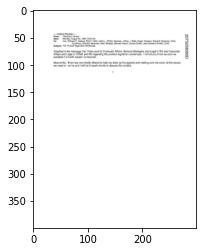

Labels: Original Message— From: Ciaveloux, Denise Sent Monday, August 2, 1990 10-08 AM Tor Cox, AlchardH; Solana, Fick P; Els, Cathy L (WSA); Seeman, Jetoy |; Walk, Roger; Sanders, Edward; Dempsey, Ruth; ‘Carchman,Fichard; Kassman, llr; Bours, Manual; Keano, Deise;Boder, Jear-Bernar: Hurwiz, Even ‘Subject: FW: Product Regulation Workshops  ‘Attached is the message that I have sent to Corporate Affairs, General Managers and Legal in EU and Corporate Afairs and Legal in CEMA and EE regarding the product regulation workshops. | will let you know as soon as possible if a fourth session is required. Meanwhile, Even has very Kindly offered to help me draw up the agenda and making sure we cover all the issues ‘we need to ~ 80 he and I willbe in touch shortly to discuss the content. 7 assogsze20z
Pred: From: Caputo, Christine on Thu, Nov 17, 1997 3:51 PM Subject: B&H Kings To: Maggio, Jim Ce: Caputo, Christine; Murillo, Joe; Mullen, Beth; Murillo, Joe; Mullen, Beth; Murillo, Joe; Mullen, Beth;

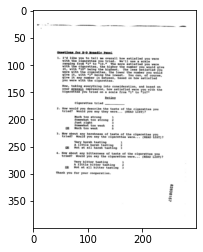

Labels: Questions for B-D Monadic Panel 1. I'd like you to tell me overall how satisfied you were with the cigarettes you tried. We'll use a scale ranging from "1" to "10." The more satisfied you were with the cigarettes, the higher the number you would give it, with "10" being’the highest. The less satisfied you were with the cigarettes, the lower the number you would give it, with "1" being the lowest. You can, of course, give it any number in between, based on how Satisfied you were with the cigarette:   Now, taking everything into consideration, and based on your overall impression, how satisfied were you with the cigarettes you tried on’a scale from "1" to "10? Rating  Cigarettes tried 2. How would’ you describe the taste of the cigarettes you tried? Would you say they were... (READ LIST)?  Much too strong Somewhat too strong Just right Somewhat too weak QR Much too weak weeny 3. How about any harshness of taste of the cigarettes you tried? Would you say the cigarettes were... (RE

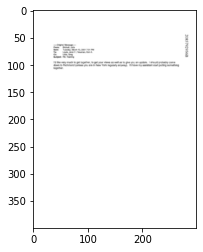

Labels: Origine! Message From: Brickall Jula Sent! Tuesday, Maren 19, 200% 7:3 PA Tor Lewis, dane V3 Newman, Ken A Ge: Lit, Greg Subject: RE: Taining  1d like very much to get together, to get your views 2s well as to give you an update. | should probably come: down to Richmond (unless you are in New York regularly anyway). Ill have my assistant start putting something together. AISOTHLS8OT
Pred: —Original Message— From: ‘Scruggs, John Sent: Monday, January 18, 2002 9:58 AM To: Hoel, John Subject: RE: NH Smoking Ban Initiative - Message Points for Regarding the NH Smoking Ban Initiative - Message Points for Regarding the NH Smoking Ban Initiative - Message Points for Regarding the NH Smoking Ban Initiative - Message Points for Regarding the NH Smoking Ban Initiative - Message Points for Regarding the Smoking Ban Initiative - Message Points for Regarding Smoking Ban Initiative - Message Points for Regarding Smoking Ban Initiative - Message Points for Regarding Smoking Ban Initiative - M

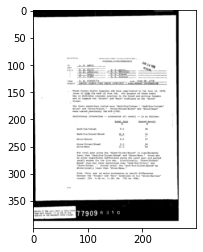

Labels: INTERNAL CORRESPONDENCE ‘Three Arctic Lighte sagazine ade vere copy-tested in the gure 12, 1978, feste of SIME the wes of June Sth. The furpose of these tests was to deternine constiner reaction to the bleed and sortise formats and to compare the "Ieiest" and “hore” headlines on the "Glove" visual. rhe three executions tected were "Pack/Ice/toleat," *pack/tse/ieient/ Diced" gna "Glove/Telest.” “Glove/Tehest/Bleed" ond “Glove/More" were tested previously (in #75-2/50) PreLininazy information ~- persuasion a1 zecall -~ is a follows: Pegved Recall % pack/rce/teleat 38 Pack/ice/tetest/Bleed 3 Glove/tetest ” Glove /ictest/Bleea 36 Glove/toxe ‘20 ‘The total post score for “Glove/iciest/aleed" is significantly lover chan "Pack/Tee/iciest/Bleed and “Glove/More.” There are no other significant differences among the total poat and proved recall scores for the five ade. Dizectionslly, “Glove/Totest/ Bleed" also has loner perovasion than "Pack/Tee/reiest” and “Gleve/Toiest .” Proved vecall

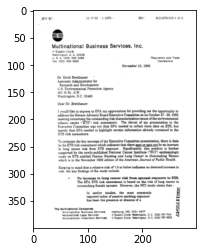

Labels: SENT BY: 1-17-82 + 1:26PM + MBS+ 912128782165: 9/11 Multinational Business Services, Inc. Ni Dupont Circle   Washington, 9. C, 20036 U.S. A. (202) 293-5286 Regulatory and Trade Fax: (202) 939-6969 Counsellors November 13, 1992 Dr. Erich Bretthauer Assistant Administrator for Research and Development U.S. Environmental Protection Agency 401 M St., S.W. Washington, D.C. 20460 Dear Dr, Bretthauer: I would like to express to EPA my appreciation for providing me the opportunity to address the Science Advisory Board Executive Committee at ita October 27 - 28, 1992 meeting concerning the outstanding risk characterization issues of the environmental tobacco smoke ("ETS") risk assessment. The thrust of my presentation to the Fxecutive Committee was not that EPA needed to collect more data on ETS, but merely that EPA needed to highlight certain information already contained in the ETS risk assessment. To reiterate the key message of my Executive Committee presentation, there is data in t

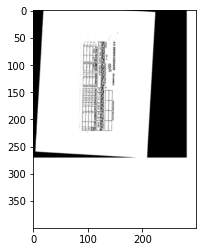

Labels:  R.H. BRUSKIN ASSOCIATES nposawpte sonnet seuecrio                          
Pred: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



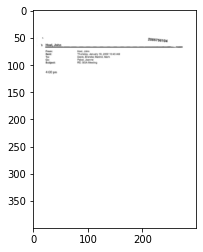

Labels: 2085756104  ¥ Hoel, John From: Hoe', John Sent: ‘Thursday, January 10, 2002 10:45 AM To: Davis, Brandie; Berlind, Mark ceo: Pabst, Joanne Subject: RE: SGA Meeting 4:00 pm
Pred: 2085787869 Pabst, Joanne From: Berlind, Mark Sent: Friday, January 17, 2002 9:41 AM To: Hurwitz, Even Subject: FW: EPA Lawsuit FYI



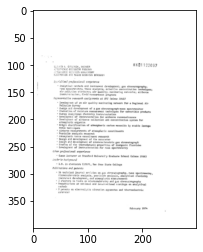

Labels:  4KG1122037 heis end instrunent cevelopzent; gas chronatography; 5 analysis; select i ‘tration techniques air quality; nonitoring netvosks; airborne iors field measurenent prograns Pepresentative research cesiganente at S21 (eine 1952)     + Zevelozreat of en air quality monitoring network for a Regional Ais Survey + Design and davelopsent of a gas chrenatograph-mass spectrometer + Evaluation of moisture measurement techniques for conestible products + Survey cxsi;ticsl chenistry instruzentat ion ‘of instruzentation for airborne reconnaissance of airborse collection and concentration system for organics. fication of atmospheric carbon monoxide by stable isotope ques. + Airborne reasurenents of atnospherfe constituents,           + Pesticide analysis research : ‘ ‘constituent research : opment of the oszo=eter : joprent of microcovlonetric gas chromatograph + Studies of the thermodynazic proverties of inorganic fluorides + Developrent of instrarentation for rass epectrozetry  Cc

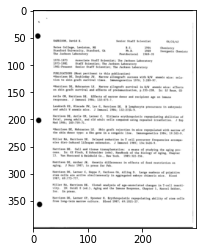

Labels:  HARRISON, David E. Senior Staff Scientist 06/26/42  Bates College, Lewiston, ME B.S. 1964 Chemistry Stanford University, Stanford, CA Ph.D. 1969 Inorganic Chemistr The Jackson Laboratory Postdoctoral 1969-70 1970-1973 Associate Staff Scientist; The Jackson Laboratory 1973-1981 Staff Scientist; The Jackson Laboratory 1981-Present Senior Staff Scientist; The Jackson Laboratory PUBLICATIONS (Most pertinent to this publication) ‘ilarrison DE, Doubleday JW. Marrow allowgraft success with W/W anemic mice: rela- tion to skin graft survival times. Immunogenetics 1976; 3:289-97.  ‘Harrison DE, Mobraaten LE. Marrow allograft survival in W/W anemic mice: effects on skin graft survival and effects of preinmunization, p.233-238. In: SJ Baum, GD Astle CM, Harrison DE. Effects of marrow donor and recipient age on immune responses. J Immunol 1984; 132:673-7, Landreth KS, Kincade PW, Lee G, Harrison DE. B lymphocyte precursors in enbryonic and adult W anemic mice. J Immunol 1984; 132:2724-9. H

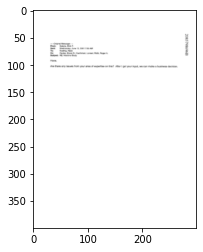

Labels: Original Mossage-~ From: Solana, Fick P Sent: Wedrosday, June 19, 2001 7:50 AM Tor Rowbhig. Hans. Ge: Daves, Bruce D.; Carchman, Loreen; Walk, Rogor A. Subject: RE: Noctine Study Hans, Are there any issues from your area of expertise on this? Aftor | got your input, we can make a business decision, 196986LS80T
Pred: Original Message From: Hoe, John Sent: Monday, February 17,2001 10:58 AM To: Poole, Jay; Poole, Jay; Poole, Jay; Poole, Jay; Poole, Jay; Trent, Katherine; McCormick, Brendan J.; Roberts, Peggy; Poole, Jay; Trent, Katherine Subject: RE: NH Smoking Ban Proposal VTIT8LS807



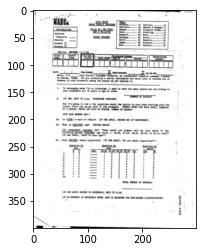

Labels: i {         Ceriton, Benson & Virginia   Study Wo. 8514001 woo # #5 -32 102  ‘BEAK TaAceaR    NO.OF  , Texas. We are conducting a survey nationcide and would like to inclule you or Soeeone in your household anong the people ve are talking to.   1. To deteraina yhon I'm to_interriew, I need to know hov many people who are living io your household are 18 years of age or older. RET OF ST 2. (IF OMG, SKIP TO @.2a, “OTHERWISE CONTINUE) Now I'm going to ask « fev questions about the adults in your hous starting with the oldest first and going dow to the youngest. (ENTER CODES FOR EACH ADULT, EXAMPLE: IF 3 ADULTS, ENTER ABC WITH NO SPACES, COMMAS OR DASHES)  (POR EACH MENGER ASK:) 2a. 3 (CODE) a sale or female? (IF ONE ADULT, RECORD SEX OF RESPONDENT) 2. What 4s (HIS/HER) age? (RECORD BELOW) ae it_refuses, SAT: *Then would you please tell ue into which of the folioving groups (WIS/HER) age falls — 18=d0; Zi-ohs 25-9i, Ss-apy ar SO or wvaeht GOP ONE ADULT, "wnat 1s your age?™) 2e Does 

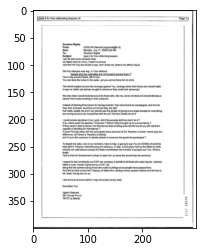

Labels:   ‘Smokers Rights From: LUGOLINI Gabrisle [cognome@tin it) Sent: ‘Monday, July 17, 2000 6:26 AM To: ‘Smokers Rights ‘Subject: pass it to Your defending lawyers Tam $4 and never smoked once. iy father told me not to, | heed his advice. ‘Row the fine You are forced to pay, and | hope not, seems me utery unjust. Did Your lawyers ever say, in Your defence i fe not forced to smoke them ‘Yes it miay sound insane, stilis tue, ‘You can take the horse to the water, yet you cannot force him to chink,  “The whole subject sounds ike revenge against You, revenge taken from those who werent able to say no, bettar yet actively sought fo smoke so they could lok growunps? ‘the only ones 1 would endorse would be those who, ike me, never smoked and should develop a ‘cancer from those smoking in thelr presence. Instead of blaming themselves for having smoked, they have found an escapegoat, and should they ever succeed, would be convinced they are right that really upsets me end can almost see the 

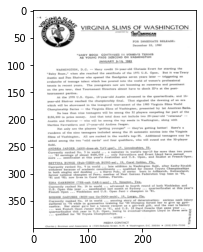

Labels: VIRGINIA SLIMS OF WASHINGTON /\MERICAN HreP atthe ones FOR IMMEDIATE RELEASE: December 22, 1982  "BABY BOOM CONTINUES Ilf WOMEN'S TENNIS "AS YOUNG PROS DESCEND ON WASHINGTON JANUARY 3-10, 1983 WASHINGTON, D.C. -- Many credit 16-year-old Chrissie Evert for starting the "Baby Boom," when she reached the semifinals of the 1971 U.S. Open. But it was Tracy ‘Austin and Pam Shriver who opened the floodgates seven years later -- triggering an avalanche of teenage talent which has poured into the world of women's professional  tennis in recent years, The youngsters now are becoming so numerous and prominent on the pro tour, that Tournament Directors almost have to check ID's at the post tournament parties. ‘At the 1978 U.S. Open, 15-year-old Austin advanced to the quarterfinals, and 16- year-old Shriver reached the championship final, That signaled the dawning of an era which will be showcased in the inaugural tournament of the 1983 Virginia Slims World the Virgint No less than nine tee

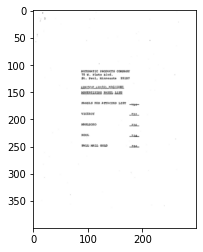

Labels: AUTOMATIC PRODUCTS COMPANY 75 W. Plato Blvd. St. Paul, Minnesota 55107  PANELS PER ATTACHED LIST _, VICEROY au MARLBORO aye KOOL 21a PALL MALL GOLD 214
Pred: APPENDIX C CURRICULUM VITAE OF VICE PRESIDENT, KURT L. MORRIS, INC. PERSONAL DATA: Date of Birth: February 2, 1943 Place of Birth: New York, New York Marital Status: Married, 3 children Business Address: Department of Psychology University of California, Los Angeles School of Medicine 950 California Street, Box 265 Los Angeles, California 90024-1465 Telephone: 310-522-7852 EDUCATION: B.A., Psychology, University of Rochester, 1959 Ph.D., Psychology, University of Rochester, 1960 POSITIONS HELD: Research Scientist, Division of Research, Lawrence Radiation Laboratory, University of California, Los Angeles, 1960-19619 1961-1964 1964-1968 1968-1969 1969-1971 1969-1971 1971-1973 1973-1974 1974- 1976- g9essse



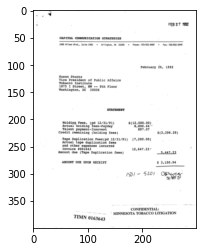

Labels: FEB 27 1992 CAPITAL COMMUNICATION STRATEGIES 1000 Wi1son Givd., Suite 2401 + Arlington, VA 22209 + Phone: 703/522-8687 + Fax: 703/522-2649 February 26, 1992 Susan Stuntz Vice President of Public Affairs Tobacco Institute 1875 I Street, NW -- 8th Floor Washington, DC 20006 STATEMENT Holding Fees, (pd 12/31/91) $(12,000.00) Actual holding fees-Payday 8,806.64 ~ Talent payment-Innovest 897.07 Credit remaining (holding fees) $(2,296.29) Tape Duplication Fees(pd 12/31/91) (7,200.00) Actual tape duplication fees and other expenses incurred Invoice #001443 12,647.23° Amount due (Tape Duplication fees) 5,447.23 AMOUNT DUE UPON RECEIPT $ 3,150.94  Isp — 5201 CBhregeay CONFIDENTIAL: - MINNESOTA TOBACCO LITIGATION TIMN 0163643
Pred:  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇  

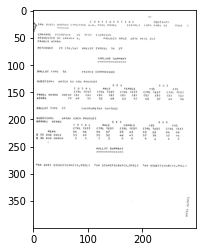

Labels: | ConFToeMTTaL yn TEST: BOUNEO FHPLOYEE U.S. NATL PANEL CEINALD   CONTROL FTZ925—A VS TEST REQUESTED BY GARNER Sy PANELS WINKG RETURNED 79 (39.54) BALLOT TYPE 1292 s-0 05-15-40  cory Fol PROJECT BOUS OATE REY: 2=7  16 24 TOPLINE SUMMARY  BALLOT TYPE 16 PAIRED © QUESTION: WHICH DO YOU PREFER?  . TOTAL CTRL TEST PANEL BRAND PRESP CR) (x) WINBS mw 49 99 BALLOT TYPE 21 THERMOME auestron: GRADE EACH PRODUCT BRAND: WINGS TOTAL CTRL TEST MEAN 64 60 X70 Awd over 5349 % 50 AnD UNDER 58 ARE VERY SIGNIFICANT(>.95CL) ASE STONIFICANT(>.90CL) OMPARISON SEX MALE FEMALE CTRL TEST CTRL TEST Co) a) a 5200 4B SS TER (0-100) Sex MALE FEMALE CTRL TEST CTRL TEST 64 6? 63 63 b> 52 45 43 73 o 0 BALLOT SUMMARY  a 745 CTRL TEST oO 0387 a 35 CTRL TEST 63 62 57 39 9 6 ss 6 6 PAGE t +45 CTRL Test (Ge) 4h 56 t +35 CTRL TEST 64 68 d2 54 4 2 ADE DIRECTIONAL (>. KALE) BSS sencs
Pred: MARKETING RESEARCH SERVICES INC.  ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇   ⁇ 

In [32]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
  pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()
  print(f'Labels: {label}\nPred: {pred}\n')

## Observações

 

**1. A performance do ViT foi bem inferior a abordagem usando a efficient-net-ConvGRU-T5.**
